In [161]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[]

# Base parameters

In [38]:
k = 8                       # number of information bits
N = 16                      # code length

nb_epoch = 2**14 
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'
arch = ['lstm-128-64-32', 'dense-128-64-32']

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

# Define NN model

In [188]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

# Data Generation

In [40]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [224]:
def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   
        # TODO vertical dimention = batch sizes
        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

# Define best train SNR

In [261]:
output_shape_test = (0, 0, 0)

In [262]:
def reshape_codebook(codebook_not_real_one):
    global N
    global output_shape_test
    output_shape_test = tf.reshape(codebook_not_real_one, (-1, N, 1))
    return output_shape_test

In [276]:
def update_model(current_arch):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    #Reshape layer
    reshape_layer = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape')]
    reshape = compose_model(reshape_layer)
    reshape.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    
    # Define decoder
    if current_arch == 'dense-128-64-32':
        decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
        for i in range(1,len(design)):
            decoder_layers.append(Dense(design[i], activation='relu'))
        decoder_layers.append(Dense(k, activation='sigmoid'))
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

    elif current_arch == 'lstm-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(16),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        

    # Define model
    if LLR:
        model_layers = modulator_layers + noise_layers  + llr_layers + decoder_layers
    else:
        model_layers = modulator_layers + noise_layers  + decoder_layers
#         model_layers = decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

In [277]:
model, decoder = update_model('lstm-128-64-32')
model.summary()

Tensor("modulator/add:0", shape=(None, 16), dtype=float32)
Tensor("modulator/add:0", shape=(None, 16), dtype=float32)
Model: "sequential_446"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 reshape (Lambda)            (None, 16, 1)             0         
                                                                 
 lstm_123 (LSTM)             (None, 16)                1152      
                                                                 
 dense_105 (Dense)           (None, 8)                 136       
                                                                 
Total params: 1,288
Trainable params: 1,288
Non-trainable params: 

In [278]:
decoder.summary()

Model: "sequential_445"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Lambda)            (None, 16, 1)             0         
                                                                 
 lstm_123 (LSTM)             (None, 16)                1152      
                                                                 
 dense_105 (Dense)           (None, 8)                 136       
                                                                 
Total params: 1,288
Trainable params: 1,288
Non-trainable params: 0
_________________________________________________________________


In [279]:
history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

Tensor("sequential_446/modulator/add:0", shape=(256, 16), dtype=float32)
Tensor("sequential_446/modulator/add:0", shape=(256, 16), dtype=float32)


In [280]:
for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):

        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,log_vector] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        nb_bits[0][i] += d_test.size
        nb_errors[0][i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]

        np.savetxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}.out', nb_bits, delimiter=', ')
        np.savetxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}.out', nb_errors, delimiter=', ')

## Polar codes

In [185]:
code = 'polar'              # type of code ('random' or 'polar')
codewords, inputs, log_vector = create_words(code)

### Train and test model

In [186]:
test_batch = 1000  
num_words = 10000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(arch),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(arch),len(sigmas)),dtype=int)

In [ ]:
%%time
for current_arch in arch:
    model, decoder = update_model(current_arch)
    
    print(f'fit {arch.index(current_arch)+1} of {len(arch)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {arch.index(current_arch)+1} of {len(arch)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = x[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[arch.index(current_arch)][i] += d_test.size
            nb_errors[arch.index(current_arch)][i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}.out', nb_errors, delimiter=', ')

### Load data

In [281]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}.out', delimiter=', ' )

### Plot Bit-Error-Rate

<ipython-input-282-bad63811b53e>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[arch.index(current_arch)]/nb_bits[arch.index(current_arch)])


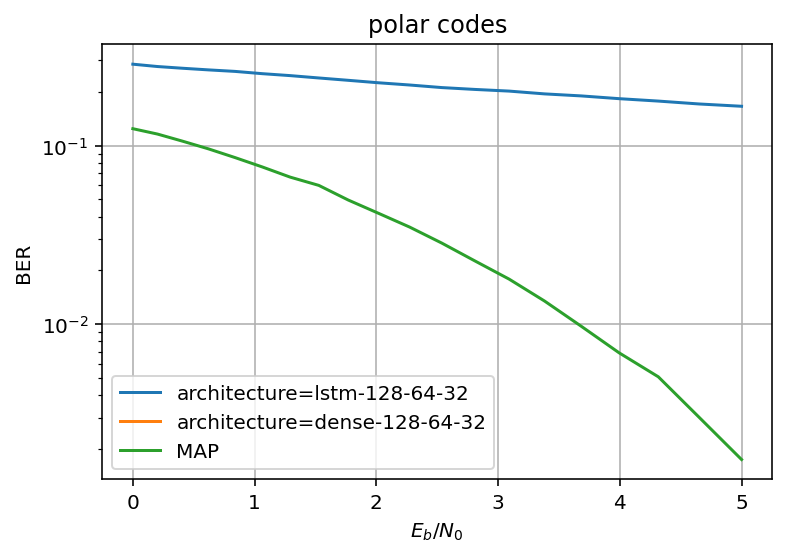

In [282]:
legend = []
for current_arch in arch:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[arch.index(current_arch)]/nb_bits[arch.index(current_arch)])
    legend.append(f'architecture={current_arch}') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

## Random codes

In [ ]:
code = 'random'              # type of code ('random' or 'polar')
codewords, inputs = create_words(code)

### Train and test model

In [13]:
test_batch = 10000  
num_words = 1000000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(LLR),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(LLR),len(sigmas)),dtype=int)

In [17]:
%%time
# inputs - words before coding 
for LLR_layer in LLR:
    model, decoder = update_model(LLR_layer)
    
    print(f'fit {LLR.index(LLR_layer)+1} of {len(LLR)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {LLR.index(LLR_layer)+1} of {len(LLR)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = codewords[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[LLR.index(LLR_layer)][i] += d_test.size
            nb_errors[LLR.index(LLR_layer)][i] аа+= decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', nb_errors, delimiter=', ')

fit 1 of 2
decode 1 of 2
fit 2 of 2
decode 2 of 2
CPU times: user 10min 14s, sys: 36.9 s, total: 10min 51s
Wall time: 11min 9s


### Load data

In [18]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )

### Plot Bit-Error-Rate

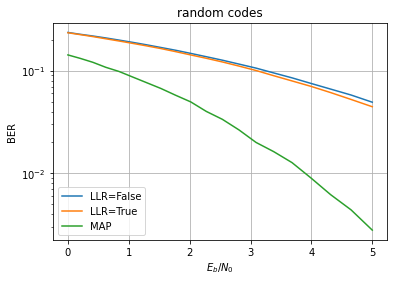

In [19]:
legend = []
for LLR_layer in LLR:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[LLR.index(LLR_layer)]/nb_bits[LLR.index(LLR_layer)])
    legend.append(f'LLR={LLR_layer}') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

In [206]:
sequence = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)

In [207]:
sequence

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [208]:

sequence = sequence.reshape((-1, n_in, 1))

In [209]:
sequence

array([[[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]])

In [223]:
def create_mix_epoch_validation(code_k, code_n, numOfWordSim, validation_snr, is_zeros_word):  # 把之前的几个函数做集成，开始做整套的编码过程
    X = np.zeros([1, code_n], dtype=np.float32)
    Y = np.zeros([1, code_k], dtype=np.int64)
    #numOfWordSim батч сайз
    x = np.zeros([numOfWordSim, code_n], dtype=np.int64)  # numOfWordSim这个玩意代入的参数是batch_size=120
    u = np.zeros([numOfWordSim, code_n], dtype=np.int64)
    d = np.zeros([numOfWordSim, code_k], dtype=np.int64)
    for sf_i in validation_snr:
        A = polar_design_awgn(code_n, code_k, sf_i)  # A是bool型的玩意，来判断这个信道是不是合适传输的
        # print("A是这个东西", A)
        # #### 在这里加入循环！！！！！！！！！！！！！！
        if is_zeros_word:  # 用全0数据训练
            d = 0 * wordRandom.randint(0, 2, size=(numOfWordSim, code_k))  # max取值只能到2，不能到1
        else:
            # 把d变成1，2,3,4,5然后转化为2进制，从而遍历所有的情况，看看是不是我的网络设置有毛病
            # for k in range(1, numOfWordSim):  # 在码长固定的情况下遍历所有的可能情况
            #   d[k] = inc_bin(d[k - 1])
            d = wordRandom.randint(0, 2, size=(numOfWordSim, code_k))  # 随机生成训练数据

        # print(d)
        # X[:,0]就是取所有行的第0个数据, X[:,1] 就是取所有行的第1个数据。
        u[:, A] = d  # u = np.zeros([numOfWordSim, code_n],dtype=np.int64) ，没毛病，u就是120*64的维度，d是120*64的随机数，0,1的随机数，A是64的bool型
        for i in range(0, numOfWordSim):
            x[i] = polar_transform_iter(u[i])

        snr_lin = 10.0 ** (sf_i / 10.0)
        noise = np.sqrt(1.0 / (2.0 * snr_lin * code_rate))
        X_p_i = random.normal(0.0, 1.0, x.shape) * noise + (1) * (1 - 2 * x)  # random.normal按照正态分布取随机数
        x_llr_i = 2 * X_p_i / (noise ** 2)
        X = np.vstack((X, x_llr_i))  # x_llr_i是接收端用来译码的对数似然信息
        Y = np.vstack((Y, d))  # u是单纯的原始码

    X = X[1:]  # X是编码加噪声后接收端处理过的对数似然信息
    Y = Y[1:]  # Y是最初未编码的0,1信息

    return X, Y

In [219]:
 X = np.zeros([1, 5], dtype=np.float32)
Y = np.ones([1,5])

In [221]:
x = np.vstack((X, Y))

In [222]:
x[1:]

array([[1., 1., 1., 1., 1.]])

In [216]:
x

array([[1, 2],
       [3, 4]])

In [217]:
x[1:]

array([[3, 4]])